분석 목표: 1회 구매자 재구매 유도 분석 + 2회 이상 구매자 재구매 이유 분석

In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/주력상품'
# file_path = f'{data_root}/2019-Nov.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
# 데이터 불러오기
top_multi_df = pd.read_parquet(f'{data_root}/multi_buyers_all_events.parquet')

In [ ]:
top_multi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53878067 entries, 0 to 53878066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_type     object 
 1   product_id     int64  
 2   category_id    int64  
 3   brand          object 
 4   price          float64
 5   user_id        int64  
 6   user_session   object 
 7   event_date     object 
 8   event_hour     int32  
 9   category_lvl1  object 
 10  category_lvl2  object 
 11  category_lvl3  object 
 12  category_lvl4  object 
 13  weekday        object 
dtypes: float64(1), int32(1), int64(3), object(9)
memory usage: 5.4+ GB


In [ ]:
print(top_multi_df['category_lvl1'].unique())

['electronics' 'appliances' 'construction']


#1. 기본 EDA + 퍼널 분석
4개 그룹 행동 특성 차이 파악
- 고객별 이벤트 흐름 분석 (view → cart → purchase 퍼널)
- 고객당 이벤트 수, 평균 세션 수, 평균 머문 시간 등 통계
- 카테고리, 브랜드, 시간대별 행동 분포

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = top_multi_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        644650
cart        633968
purchase    645198
Name: user_id, dtype: int64
view_to_cart: 0.9834297680912123
cart_to_purchase: 1.017713827827272
view_to_purchase: 1.000850073683394


#재구매에 이른 고객들의 전형적인 행동 흐름 분석

| 항목                  | 분석 방식                 | 시사점                   |
| ------------------- | --------------------- | --------------------- |
| **view → cart 전환율** | 다회 구매자 vs 1회 구매자 비교   | 관심→구매 유도력 차이          |
| **cart 보유 시간**      | cart 이후 구매까지 평균 시간    | 구매 망설임/결정 시간 차이       |
| **브랜드/카테고리 다양성**    | 다회 구매자는 다양한 카테고리 탐색?  | 1회 구매자는 특정 상품군에만 관심?  |
| **세션 간격**           | 첫 방문 \~ 다음 방문까지 평균 시간 | 다음 방문을 유도할 마케팅 타이밍 판단 |
| **세션 수 / 머문 시간**    | 더 오래 탐색하고 비교했는가?      | 충동구매 vs 숙고구매 여부       |

In [ ]:
#1.구매 간격(재구매 주기)
# event_date를 datetime으로 변환
top_multi_df['event_date'] = pd.to_datetime(top_multi_df['event_date'])

# 구매 이벤트만 추출
purchase_top_multi_df = top_multi_df[top_multi_df['event_type'] == 'purchase']

# 유저별 구매 일자 정렬
purchase_top_multi_df = purchase_top_multi_df.sort_values(by=['user_id', 'event_date'])

# 각 유저의 구매 간격 계산 (days)
purchase_top_multi_df['purchase_gap'] = purchase_top_multi_df.groupby('user_id')['event_date'].diff().dt.days

# 평균 구매 간격
avg_gap = purchase_top_multi_df['purchase_gap'].mean()
print(f"평균 구매 간격(일): {avg_gap}")

평균 구매 간격(일): 7.867477718307534


In [ ]:
#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = top_multi_df[top_multi_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (top_multi_df[top_multi_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

user_session
00000083-8816-4d58-a9b8-f52f54186edc    [view, view, view, view, view, view, view, vie...
000001fd-1f89-45e8-a3ce-fe3218cabfad    [view, view, view, view, cart, view, cart, car...
0000138c-b861-4c6a-8abb-ed43b1def8e2                         [view, view, cart, purchase]
00001b7d-1090-45e1-8130-0b683911631f                               [view, cart, purchase]
00002469-20b6-4603-8fa1-51e78f062bd2    [view, cart, purchase, view, cart, purchase, v...
00002495-fc82-44f0-b008-7a09baca1cb6                               [view, cart, purchase]
0000256d-010c-47da-bcef-cf2c1017bcf6    [view, view, view, view, view, view, cart, pur...
0000266c-6ae3-48f2-abc6-44189d2ff64a    [view, cart, cart, view, cart, purchase, view,...
00002680-2bc1-4c1e-9195-31f3c9399018                   [view, cart, purchase, view, view]
00002b33-422d-4a07-a3c1-0193afd045d3    [view, view, view, view, view, view, view, car...
Name: event_type, dtype: object


In [ ]:
#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = top_multi_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = top_multi_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

평균 세션 수: 15.730442437825287
평균 이벤트 수: 83.50625234424162


In [ ]:
#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = top_multi_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = top_multi_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

평균 탐색 카테고리 수: 2.1977997451944984
평균 브랜드 수: 8.471027498535333


In [ ]:
#5. 요일/시간대 분석
# 요일별 구매 수
weekday_purchase = purchase_top_multi_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_top_multi_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Sunday       538457
Monday       506652
Tuesday      473250
Saturday     473231
Wednesday    464627
Friday       456371
Thursday     446946
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0      87907
1      55917
2      35316
3      23305
4      15851
5      14673
6      20873
7      48584
8     111357
9     169380
10    204093
11    224480
12    237447
13    248572
14    249765
15    239927
16    220104
17    202231
18    189831
19    179926
20    168095
21    154583
22    140351
23    116966
Name: count, dtype: int64


요일별, 시간대별 구매 수 시각화(막대 그래프)

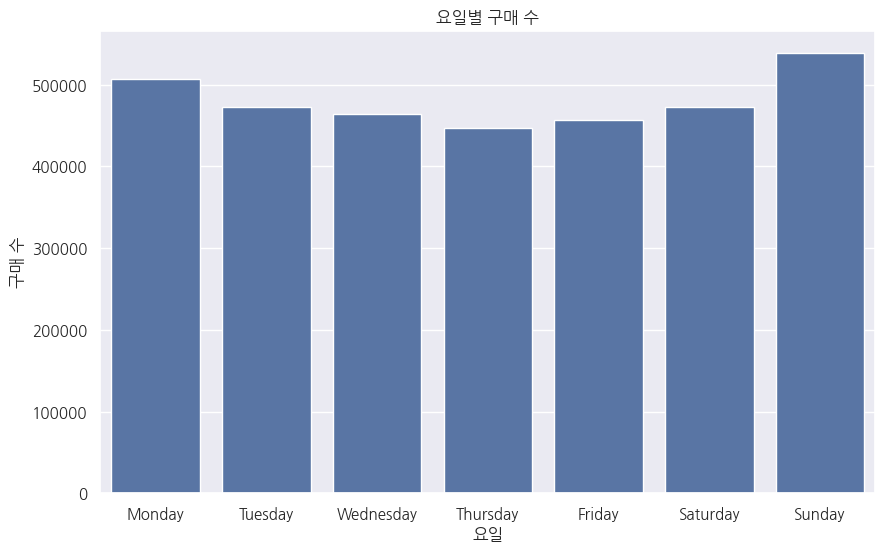

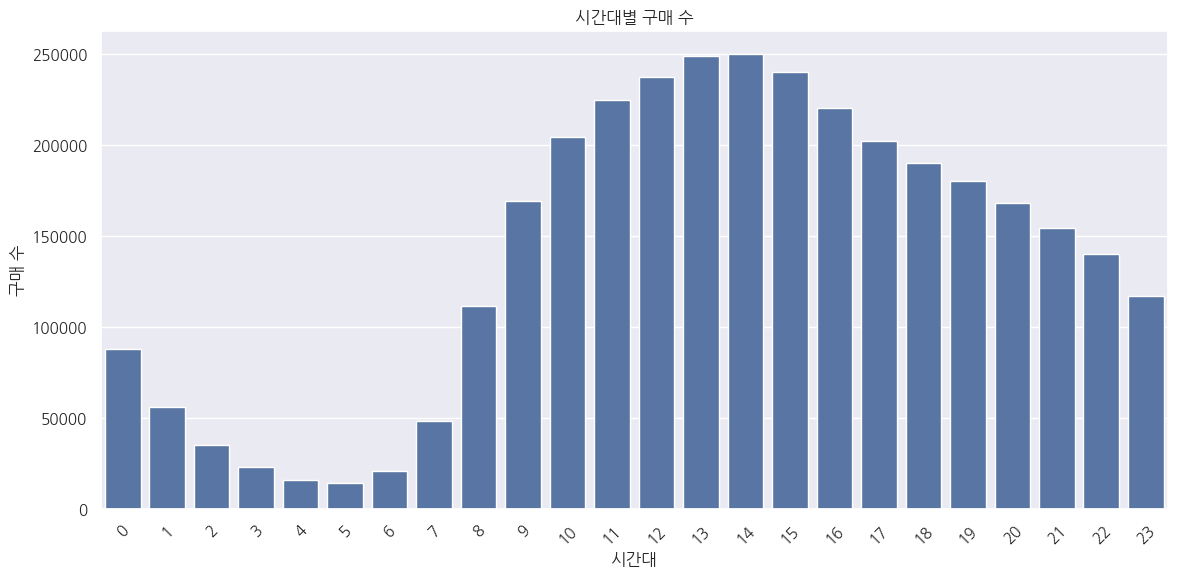

In [ ]:
# 요일별 구매 수 시각화
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

다회 구매자의 첫 구매 행동 패턴 분석

In [ ]:
# 첫 구매 이전 cart -> purchase 시간 계산
# 1. event_datetime 컬럼 생성
top_multi_df['event_datetime'] = top_multi_df['event_date'] + pd.to_timedelta(top_multi_df['event_hour'], unit='h')
top_multi_df['event_datetime'] = pd.to_datetime(top_multi_df['event_datetime'])

# 2. 각 유저의 첫 purchase 시간 구하기
first_purchase_time = top_multi_df[top_multi_df['event_type'] == 'purchase'] \
                        .groupby('user_id')['event_datetime'].min() \
                        .rename('first_purchase_time')

# 3. 첫 구매 이전의 행동만 필터링
top_multi_df = top_multi_df.join(first_purchase_time, on='user_id')
top_multi_df_first_purchase = top_multi_df[top_multi_df['event_datetime'] <= top_multi_df['first_purchase_time']].copy()

# 4. 해당 구간 내에서 cart/purchase 시점 추출
df_cart = top_multi_df_first_purchase[top_multi_df_first_purchase['event_type'] == 'cart']
df_purchase = top_multi_df_first_purchase[top_multi_df_first_purchase['event_type'] == 'purchase']

cart_times = df_cart.groupby('user_id')['event_datetime'].min()
purchase_times = df_purchase.groupby('user_id')['event_datetime'].min()

# 5. 공통 user_id 기준 병합 및 시간 차 계산 (단위: 시간)
merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))
cart_hold_time_first_purchase = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600


In [ ]:
print("평균 Cart 보유 시간 (시간):", cart_hold_time_first_purchase.mean())

평균 Cart 보유 시간 (시간): 131.43819934974195


In [ ]:
print(cart_hold_time_first_purchase.describe())

count    573926.000000
mean        131.438199
std         428.595918
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        4297.000000
dtype: float64


즉시 구매자가 많음(cart와 purchase를 같은 시각에 기록): 할인·광고 유도, 혹은 상품에 확신이 있는 경우 자주 발생

구매 경험이 있는 다회 구매자 중 일부는 확신을 갖고 행동할 수 있음

In [ ]:
# 즉시 구매자 비율 확인
instant_buyers_ratio = (cart_hold_time_first_purchase == 0).mean() * 100
print(f"즉시 구매자 비율: {instant_buyers_ratio:.2f}%")

즉시 구매자 비율: 69.10%


| 관찰                        | 가능성 있는 해석                                |
| ------------------------- | ---------------------------------------- |
| 🔹 첫 구매에서조차 망설이지 않음       | 이미 구매 의도가 명확했던 고객                        |
| 🔹 cart는 단순히 구매 절차의 일부일 뿐 | 제품 탐색은 이미 끝났거나, 광고/추천의 영향을 받아 명확한 니즈로 진입 |
| 🔹 다회 구매자가 될 가능성이 높았던 유저  | 첫 구매부터도 신뢰·확신을 기반으로 행동한 유저들              |

- 1회 구매자 평균 cart 보유 시간이 더 길고, 이는 그들이 첫 구매를 더 오래 고민했다는 증거

- 결국, 첫 구매를 신속하게 한 고객은 다회 구매로 이어질 가능성이 높고,

- 첫 구매를 오래 망설인 고객은 1회에서 이탈할 가능성이 높다는 가설을 세울 수 있음

=> 즉시 구매자 타겟: 광고·이벤트 노출만으로 빠르게 반응할 가능성 높음

=> 비즉시 구매자 타겟: 장바구니 리마인드, 장기 고려용 정보 제공(리뷰, 비교 등)이 더 효과적

"첫 구매에서 즉시 결제하지 않은 30% 이상 유저는 리텐션 가능성이 상대적으로 낮으며, 이들에게는 추가적인 자극이 필요하다."

In [ ]:
# 층화 샘플링 750 데이터 불러오기
df_sampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories_750.csv')